*Load packages and data:*

In [1]:
%run stdPackages.ipynb
read = {'variables': ['Fundamentals', 'Load', 'Generators_Other','TL','Regulation'], 
        'variable2D': ['Generators_FuelMix','HourlyVariation'],
        'scalars': ['Scalars'],
        'maps': ['Generators_Categories', 'Load_Categories']}
db = dbFromWB(os.path.join(d['data'],'E3.xlsx'), read)
readSets(db)

# Exercise 3: The value of transmission lines and the cost of intermittency

### Problem 1: Gains of trade

Let us start with a few observations for $g1,g2$:
* Recall from exercise 2 that the market $g1$ consists of four types of plants with the merit order of dispatching: Wind, coal, natural gas, biomass. In that model, the hours $h=1,4$ were characterized by relatively small demand and cheap marginal supply (from coal). In hours $h=3$, however, the marginal supply is instead from the more expensive biomass, and in $h=3$ some load has to be shedded to establish equilibrium.
* For the The market $g2$ uses solar (PV) and natural gas only. In hours $h=1,2,4$ the marginal supply comes from natural gas; in hour $h=3$ the load has to shedded here as well.

With this in mind: We can expect $g1$ to export in hours $h=1,4$ and $g2$ to export in $h=2$. Let us confirm that this is the case:

*Set up and solve:*

In [2]:
m = mBasicTrade.mBasicTrade(db)
m.solve()

Solution status 0: Optimization terminated successfully.


*Inspect exports:*

In [3]:
m.db['Transmission'].unstack('h')

,h,1,2,3,4
g,g_alias,,,,
g1,g2,25.0,0.0,0.0,25.0
g2,g1,0.0,17.5,0.0,0.0


* The positive values in $h=1,4$ for $(g1,g2)$ indicate that $g1$ exports to $g2$ in these hours.
* The positive value in $h=2$ for $(g2,g1)$ indicates that $g2$ exports to $g1$ in these hours.

### Problem 2: Gains of trade

We vary ```lineCapacity``` from 0-100 GJ with 21 grid points and use the ```loopSolveExtract``` method applied in previous exercises:

i) Create loop:

In [4]:
loop = pd.Index(range(21), name = 'loop')

ii) Create grid of values to update throughout the loop by specifying first (```v0```) and final value in the loop (```vT```):

In [5]:
v0 = db['lineCapacity'] * 0
vT = db['lineCapacity'] * 4
grid = addGrid(v0,vT,loop,'lineCapacity')

iii) Specify which symbols to save in the simulations:

In [6]:
extract = ['marginalSystemCosts','congestionRent','marginalEconomicValue']

iv) Run simulation:

In [7]:
solution = m.loopSolveExtract(loop,[grid],extract)

Let us consider each of the variables in turn:

#### 2.1. *Marginal system costs:*


The variable is defined over $(g,h,loop)$. Let us print a separate plot for each hour:

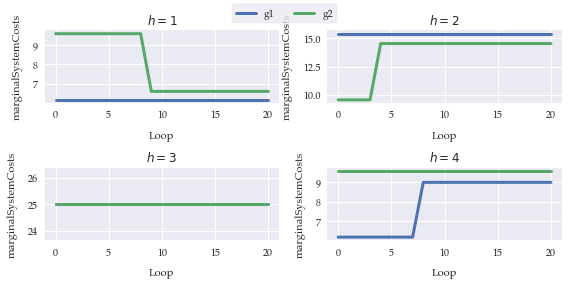

In [8]:
nplots = len(db['h'])
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (8, (2*nrows)));
plt.subplots_adjust(hspace=0.35) # create a bit of extra space between subplots

for j in range(nplots):
    ax = plt.subplot(nrows, min(nplots,2), j+1) # access subplot j+1
    df = solution['marginalSystemCosts'].xs(j+1,level='h').unstack('g')
    df.plot(ax=ax, legend=False, linewidth=3);
    ax.set_xlabel('Loop', labelpad=10); # set label on the x-axis; labelpad specifies distance from axis to edges of the plot 
    ax.set_ylabel("marginalSystemCosts", labelpad=10); # set label on the y-axis
    ax.set_title(f"""$h={j+1}$""")

fig.legend(df.columns, loc = 9, ncol = 2, frameon=True) # add columns as legends above the plot
fig.tight_layout(); # auxiliary function that often makes the plot look a bit nicer
fig.subplots_adjust(top=0.9); # make room for the legends to be above the plot

* The marginal system costs are always identical in $h=3$; this is because the equilibrium is characterized by load shedding - thus, trade does not help in this scenario.
* In hour $h=1$ the marginal supply comes from coal in $g1$ and natural gas in $g2$. There is sufficient excess capacity of coal in $g1$, however, to export to $g2$ such that this coal plant is the marginal supply in $g2$ as well. So, the marginal system costs drop to (near) to the cost in $g1$ once the transmission capacity is large enough.
* In hour $h=2$ the marginal supply comes from biomass in $g1$ and gas in $g2$. There is, however, not that much excess capacity of gas in $g1$. Thus, when transmission capacities increase, the marginal system costs increase instead of decrease (as it happened in $h=1$).
* In hour $h=4$ we have a similar situation as to $h=2$, but with the reverse trade flows: marginal supply is coal in $g1$ and gas in $g2$. When transmission capacities increase however, the marginal system costs increase instead of decreasing. This is because natural gas becomes the marginal supplier (and not the coal plant). 

#### 2.2. *Congestion rent:*


The variable is defined over $(g,g',h,loop)$. We sum over $(g,g')$ and plot for each hour:

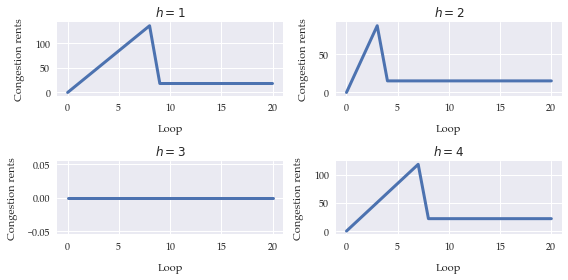

In [9]:
nplots = len(db['h'])
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (8, (2*nrows)));
plt.subplots_adjust(hspace=0.35) # create a bit of extra space between subplots

for j in range(nplots):
    ax = plt.subplot(nrows, min(nplots,2), j+1) # access subplot j+1
    df = pdSum(solution['congestionRent'], ['g','g_alias']).xs(j+1,level='h')
    df.plot(ax=ax, legend=False, linewidth=3);
    ax.set_xlabel('Loop', labelpad=10); # set label on the x-axis; labelpad specifies distance from axis to edges of the plot 
    ax.set_ylabel("Congestion rents", labelpad=10); # set label on the y-axis
    ax.set_title(f"""$h={j+1}$""")

fig.tight_layout(); # auxiliary function that often makes the plot look a bit nicer

The congestion rents are all increasing initially in the installed transmission capacity: This is all driven by increases in trade flows, $x_{l,h}$. Once we reach a certain threshold (different ones for each hour), the system marginal costs are (almost entirely) equalized across $g_1,g_2$. At this point, the congestion rents drop significantly and stays constant after this. Note that congestion rents do not drop to exactly zero, because system marginal costs are not entirely equalized; this is due to costs of operating the lines (```lineMC```) and the line losses (```lineLoss```).

#### 2.3. *Marginal Economic Value*

Plot the marginal economic value in separate plots to make it easier to inspect:

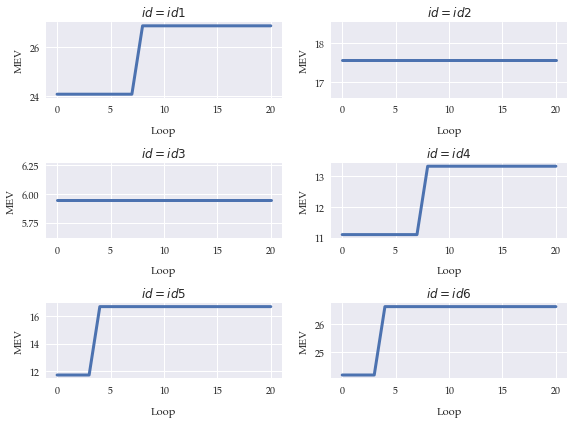

In [10]:
nplots = len(db['id'])
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (8, (2*nrows)));
plt.subplots_adjust(hspace=0.35) # create a bit of extra space between subplots

for j in range(nplots):
    ax = plt.subplot(nrows, min(nplots,2), j+1) # access subplot j+1
    s = solution['marginalEconomicValue'].xs(db['id'][j],level='id')
    s.plot(ax=ax, legend=False, linewidth=3);
    ax.set_xlabel('Loop', labelpad=10); # set label on the x-axis; labelpad specifies distance from axis to edges of the plot 
    ax.set_ylabel("MEV"); # set label on the y-axis
    ax.set_title(f"""$id={db['id'][j]}$""")
fig.tight_layout(); # auxiliary function that often makes the plot look a bit nicer

Note that for all plants, the *marginal economic value* of capacity increases in the transmission capacity. Note that the PV plant (```id6```) has the highest marginal economic value, whereas the wind plant (```id4```) is in the lower end. This is primarily because the PV plant has a positive correlation with demand, whereas the plant has a negative correlation.

### Problem 3: Coordinated/uncoordinated regulation

To see the effect of the coordinated/uncoordinated regulation, We start by setting up a model class that includes cap on emissions, set up a grid to solve the model on:

In [15]:
m = mBasicTrade.mBasicTrade_EmissionCap(db)
m.db['lineCapacity'] = 25
# Problem loop:
loop = pd.Index(range(11), name = 'loop') # number of gridpoints.
v0 = pd.Series(25, index = m.db['g']) # start with cap on 25/25.
vT = pd.Series(10, index = m.db['g']) # end with cap 10/10.
grid = addGrid(v0,vT,loop,'CO2Cap') # grid
# Simulate with common cap and without:
sol_coordinated = m.loopSolveExtract(loop, [grid], ['Welfare','meanConsumerPrice','Generation','Emissions'])
m.commonCap = False
sol_uncoordinated = m.loopSolveExtract(loop, [grid], ['Welfare','meanConsumerPrice','Generation','Emissions'])

Next, let's plot the effect on welfare:

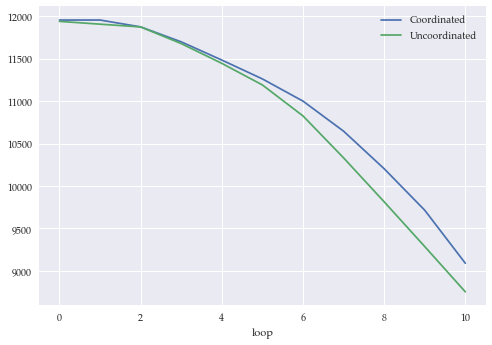

In [16]:
pd.DataFrame({'Coordinated': sol_coordinated['Welfare'], 'Uncoordinated': sol_uncoordinated['Welfare']}).plot();

Naturally, the uncoordinated regulation is not as cost-effective as the coordinated one. The reason is that *marginal abatement costs* of emissions are not equalized across the two areas, when the regulation is uncoordinated. 

To see this, let's consider the generation in coordinated vs. uncoordinated cases. One quick way to look at this is to plot the differences between coordinated/uncoordinated solutions:

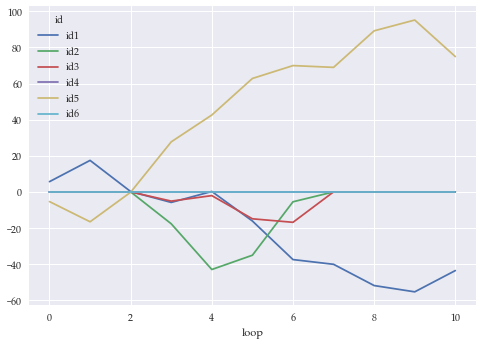

In [17]:
diff = pdSum(sol_coordinated['Generation']-sol_uncoordinated['Generation'],'h') # difference in generation
diff.droplevel('g').unstack('id').plot();

So, what happens is:
* In the *coordinated case*, the emission constraint (50) is actually not initially binding (look at ```Emissions``` variable to verify): Emissions are roughly $26$ tonnes CO2 from $g_1$ and $20$ from $g_2$. 
* In the *uncoordinated case* (constraints are 25/25), however, the constraint is binding in $g_1$. Thus, to reduce emissions down to 25, some of the coal production is replaced by imports of natural gas from $g_2$. 
* We note that in general the cheapest way to reduce emissions is still by replacing coal in $g_1$ with natural gas from $g_2$; this is what happens with the coordinated regulation. With uncoordinated regulation, the reductions have to occur in $g_2$ as well - so, the reduction in coal from $g_1$ is slower.

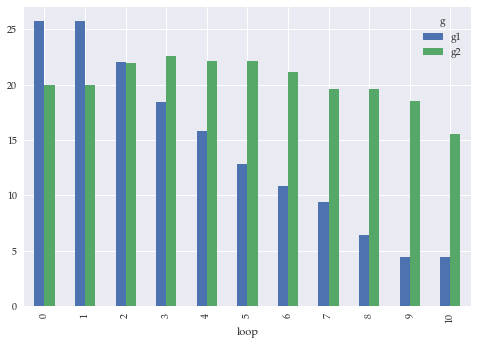

In [25]:
sol_coordinated['Emissions'].xs('CO2',level='EmissionType').unstack('g').plot.bar();